# Preamble

In [ ]:
import torch
import numpy as np
import seaborn as sns
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from hierarchical_smoothing.datasets import *
from hierarchical_smoothing.utils import *
from hierarchical_smoothing.graphs.models import *
from hierarchical_smoothing.graphs.training import *
from hierarchical_smoothing.graphs.smoothing import *
from hierarchical_smoothing.cert import certify

In [ ]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8 

# Model

In [ ]:
hparams = {
    "device": "cuda",
    "datatype": "graphs",
    "dataset_path": "../data/graphs/",
    "dataset": "cora_ml",

    # model
    "arch": "GAT",
    "protected": True,
    "in_channels": 2879 ,
    "k_heads": 8,
    "hidden_channels": 8,
    "out_channels": 7,
    "with_skip": False,

    # training
    "lr": 0.001,
    "weight_decay": 5e-4,
    "max_epochs": 1_000,
    "early_stopping": 50,
    "p_dropout": 0.5,
    "conv_dropout": 0.2,
    "logging": False,

    "alpha": 0.01,
    "n0": 1_000,
    "n1": 10_000,

    "smoothing_config" : {
        "smoothing_distribution": "hierarchical_sparse",
        "append_indicator": True,
        "p_plus": 0.05,
        "p_minus": 0.8,
        "p": 0.81
    }
}

In [ ]:
seed = 42

data = load_dataset(hparams, seed=42)
[A, X, y, n, d, nc, train, valid, test, idx_train, idx_valid, idx_test] = data
data_train = prepare_graph_data(train, hparams['device'])
data_valid = prepare_graph_data(valid, hparams['device'])
data_test = prepare_graph_data(test, hparams['device'])

set_random_seed(seed)
model = create_gnn(hparams)

In [ ]:
training_data = (data_train, data_valid, idx_train, idx_valid)
model = train_gnn_inductive(model, training_data, hparams)
model.eval()

In [ ]:
# alternatively:
# model = torch.load("../data/precomputed/pretrained_GAT_CoraML.pt")

# Smoothed Predictions (Inference)

In [ ]:
pre_votes = smooth_graph_classifier(hparams, model, data_test, hparams["n0"])
votes = smooth_graph_classifier(hparams, model, data_test, hparams["n1"])

In [ ]:
# alternatively:
# [pre_votes, votes] = torch.load("../data/precomputed/precomputed_votes_GAT_CoraML.pt")

In [ ]:
pre_votes = pre_votes[idx_test]
votes = votes[idx_test]
y_hat = pre_votes.argmax(1)
y = data_test.y.cpu()
correct = (y_hat == y).numpy()
clean_acc = correct.mean()
print(f"Clean ACC: {clean_acc}")

Clean ACC: 0.8616600790513834


# Certificate

In [ ]:
certificates = certify(correct, votes, pre_votes, hparams)

In [ ]:
plot_data = {r:certificates['multiclass']['cert_acc'][r] for r in range(5)}

In [ ]:
sns.set_style("whitegrid")
sns.set_context("notebook")

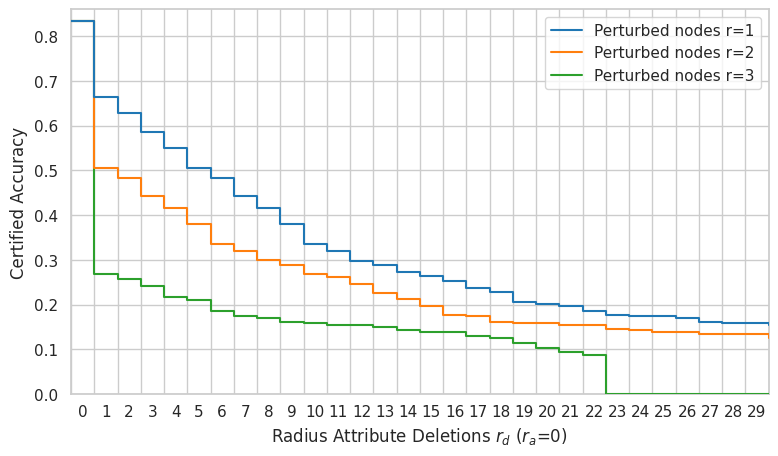

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(9,5))

for radius in plot_data:
    if radius in [0,4]:
        continue
    cert = plot_data[radius][0,:]
    label = f"Perturbed nodes r={radius}"
    x, y = range(cert.shape[0]), cert
    plt.step(x, y, where="post", label=label, zorder=100-radius)

end = cert.shape[0]
plt.xlim((0, 30))
plt.ylim((0, 0.86))
xticks = np.arange(30)
plt.xticks(xticks)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator(xticks + 0.5))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(xticks))
ax.set_xlabel("Radius Attribute Deletions $r_d$ ($r_a$=0)")
ax.set_ylabel("Certified Accuracy")
ax.legend()
plt.show()

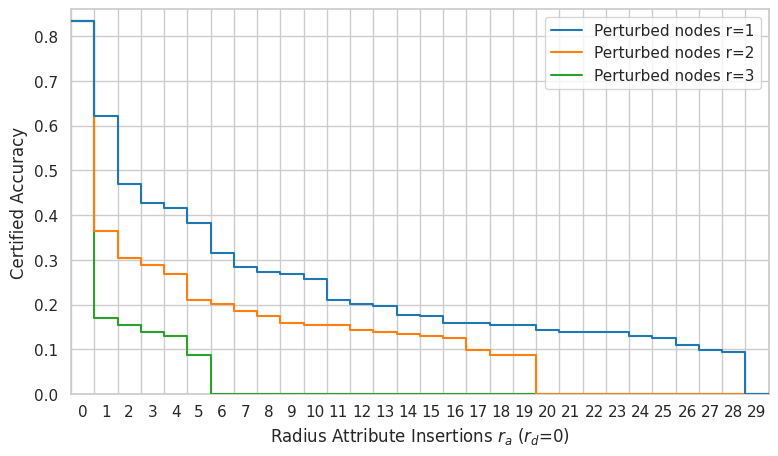

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(9,5))

for radius in plot_data:
    if radius in [0,4]:
        continue
    cert = plot_data[radius][:,0]
    label = f"Perturbed nodes r={radius}"
    x, y = range(cert.shape[0]), cert
    plt.step(x, y, where="post", label=label, zorder=100-radius)

end = cert.shape[0]
plt.xlim((0, 30))
plt.ylim((0, 0.86))
xticks = np.arange(30)
plt.xticks(xticks)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator(xticks + 0.5))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(xticks))
ax.set_xlabel("Radius Attribute Insertions $r_a$ ($r_d$=0)")
ax.set_ylabel("Certified Accuracy")
ax.legend()
plt.show()